# Bag of Features Multi-Class Classification

This notebook contains the pipeline that allows to perform classification experiments of the Multi-Class version of this problem. **Cardboard**, **Metal**, **Paper**, **Glass**, and **Plastic** are the classes that are considered in this set of experiments. The used <u>data set</u> may be found in the following [Kaggle Repository](https://www.kaggle.com/asdasdasasdas/garbage-classification). 

clean_research_practice1_version.ipynb set the baseline in order to work with in this notebook, the binary classification version of the problem is worked in there. In case of doubts, this should be the reference to be consulted.

# Imports




In [1]:
# %%capture
# # Import helper functions
# !wget https://raw.githubusercontent.com/daoterog/Solid_Domestic_Waste_Image_Classification/main/helper_functions/file_management.py
# !wget https://raw.githubusercontent.com/daoterog/Solid_Domestic_Waste_Image_Classification/main/helper_functions/evaluation_functions.py
# !wget https://raw.githubusercontent.com/daoterog/Solid_Domestic_Waste_Image_Classification/main/helper_functions/image_processing.py

In [1]:
import os
import errno

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from file_management import bring_data, walk_through_dir, copy_folder
from image_processing import (center_image_IDG, get_visual_dictionary, 
                              get_histogram, applypca, applynmf)
from evaluation_functions import (hyperparametertunning, learningcurve, 
                                  plotlearningcurve, multiclass_CV, 
                                  print_wrong_predictions)

import tensorflow as tf

# from google.colab import drive
# drive.mount('/content/drive/', force_remount=True)

 # Preprocessing

## Load the Data

In [2]:
# path_list = ['/content/drive/MyDrive/PI2/data/cardboard.zip',
#             '/content/drive/MyDrive/PI2/data/metal.zip',
#              '/content/drive/MyDrive/PI2/data/glass.zip',
#              '/content/drive/MyDrive/PI2/data/paper.zip',
#              '/content/drive/MyDrive/PI2/data/plastic.zip']

# # Unzip the data
# bring_data(path_list=path_list)

# How many images/classes are there?
walk_through_dir("data/raw_data")

There are 5 directories and 0 images in 'data/raw_data'.
There are 0 directories and 403 images in 'data/raw_data\cardboard'.
There are 0 directories and 501 images in 'data/raw_data\glass'.
There are 0 directories and 410 images in 'data/raw_data\metal'.
There are 0 directories and 594 images in 'data/raw_data\paper'.
There are 0 directories and 482 images in 'data/raw_data\plastic'.


## Run Processing Funtions

In [4]:
# Image paths
image_dir = 'data/data_augmentation/'

IMG_SIZE = (100, 100)
COLOR_MODE = "grayscale"
CLASSES = ['cardboard', 'glass', 'metal', 'paper', 'plastic']
BATCH_SIZE = 32
CLASS_MODE = 'sparse'
SHUFFLE = False
N = 403

params = dict(target_size=IMG_SIZE, color_mode=COLOR_MODE, 
              class_mode=CLASS_MODE, shuffle=SHUFFLE)

# Create Image Data Generator
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=center_image_IDG)

# Processing techniques included
data_gen = image_generator.flow_from_directory(directory=image_dir, 
                                               batch_size = 2885,
                                               classes=CLASSES,
                                               **params)

# Extracting train and test images and labels
images, labels = data_gen.next()

# Convert labels into dataframe to extract random samples
labels_df = pd.DataFrame(labels)

# Extract random samples of the data with their indices and concatenate them
cardboard = labels_df[labels_df[0] == 0].sample(N).index.tolist()
glass = labels_df[labels_df[0] == 1].sample(N).index.tolist()
metal = labels_df[labels_df[0] == 2].sample(N).index.tolist() 
paper = labels_df[labels_df[0] == 3].sample(N).index.tolist()
plastic = labels_df[labels_df[0] == 4].sample(N).index.tolist()
indexes = cardboard + glass + metal + paper + plastic
indexes = np.sort(indexes)

# Choose balanced images
balanced_images = images[indexes]
balanced_images = balanced_images.reshape(balanced_images.shape[:-1])
balanced_labels = labels[indexes]
image_filenames = np.array(data_gen.filenames)[indexes]

Found 2885 images belonging to 5 classes.


## Bag of Features

In [5]:
# BoF
patch_size, step_size = 10,3
n_words = 40

# Bag of Features
vdict = get_visual_dictionary(balanced_images, patch_size, step_size, n_words)
Xh = [get_histogram(img, patch_size, step_size, vdict) \
      for img in balanced_images]
Xh = np.array(Xh)

Xh = pd.DataFrame(Xh)
Xh.fillna(0, inplace = True)

# Assign y
y = balanced_labels

## Print n images

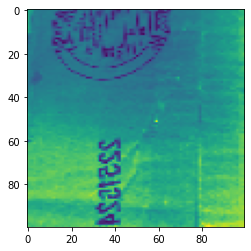

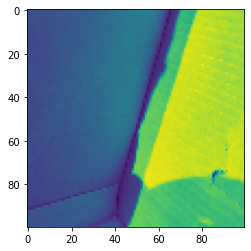

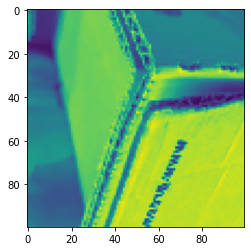

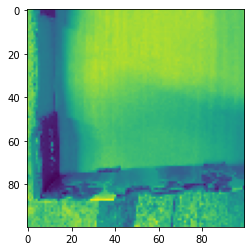

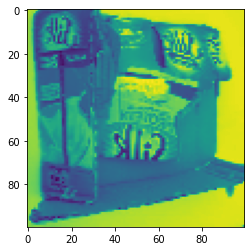

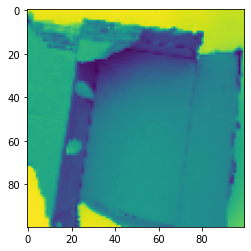

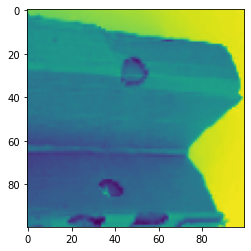

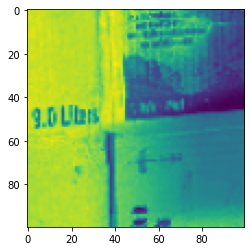

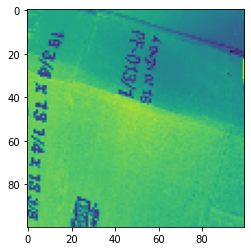

In [6]:
n = 10

for img in balanced_images[1:n]:
    plt.imshow(img[:,:])
    plt.show()

## Dimension Reduction

In [7]:
# Apply PCA
Xh_pca, pca = applypca(Xh) 

variance = pca.explained_variance_ratio_

suma = 0
cont = 0
while suma < 0.8:
  suma += variance[cont]
  cont += 1

Xh_pca80 = Xh_pca.iloc[:,:cont]

# Apply NMF
Xh_nmf, nmf = applynmf(Xh, cont)

print("Original BoF shape:",Xh.shape)
print("BoF PCA shape:",Xh_pca.shape)
print("BoF PCA80 shape",Xh_pca80.shape)
print("BoF NMF shape",Xh_nmf.shape)

Original BoF shape: (2015, 40)
BoF PCA shape: (2015, 40)
BoF PCA80 shape (2015, 8)
BoF NMF shape (2015, 8)


C:\Users\danie\miniconda3\envs\ds\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


# Model Evaluation
## Experiment Setting

In [40]:
# Create Directory
root = 'experiments/'
# destination = '/content/drive/MyDrive/PI2/experiments'

try:
    os.mkdir(root)
except OSError as e:
    if e.errno == errno.EEXIST:
        print('Directory already exist')
    else:
        raise

# Create Experiment Directory
experiment = str(input('Type Experiment Name: '))
path = root + experiment
try:
    os.mkdir(path)
except OSError as e:
    if e.errno == errno.EEXIST:
        print('Directory already exist')
    else:
        raise
model_name = str(input('Type Model Name: '))

# Create training dictionary
X_dict = {'BoF':Xh,'BoF-PCA':Xh_pca,'BoF-PCA80':Xh_pca80,'BoF-NMF':Xh_nmf}

Directory already exist
Type Experiment Name: baseline_aug_Ada
Type Model Name: AdaBoost


## Hyperparameter Tunning

In [41]:
%%capture

# Classifier - AdaBoost
tree = DecisionTreeClassifier(max_depth=8)
model = AdaBoostClassifier(tree)
hyperparameters = {'n_estimators': [50, 100, 250],
                  'learning_rate': [0.5, 1, 1.5]}

# Classifier - Random Forest
# model = RandomForestClassifier(n_jobs=-1)
# hyperparameters = {'n_estimators': [100, 250, 500],
#                   'max_depth': [4, 8, 16, 32],
#                   'criterion': ['gini', 'entropy']}

# # Classifier - SVM
# model = SVC(probability=True)
# hyperparameters = {'C': [0.1, 1, 10, 100, 1000],
#               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
#               'kernel': ['rbf', 'sigmoid', 'linear']}

# Classifier - Gaussian Naive Bayes
# model = GaussianNB()
# hyperparameters = {}


# Classifier - Logistic
# model = LogisticRegression(multi_class='multinomial')
# hyperparameters = {'C': np.logspace(0,4,10), 
#                    'penalty': ['l1','l2','elasticnet','none']}

# Tune Hyperparameters
param_dict, param_title_dictionary = hyperparametertunning(model, X_dict, y, 
                                                           hyperparameters, 5, 
                                                           'f1_macro')

## Learning Curves

In [42]:
%%capture
(train_sizes_dict, train_scores_mean_dict, train_scores_std_dict,
  test_scores_mean_dict, 
  test_scores_std_dict) = learningcurve(model, X_dict, y, 
                                        5, param_dict, 'f1_macro', 
                                        np.linspace(0.1,1,50))

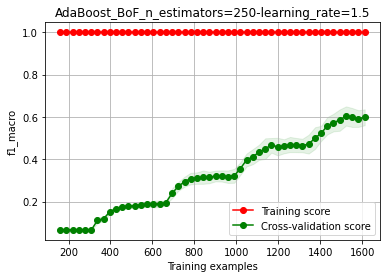

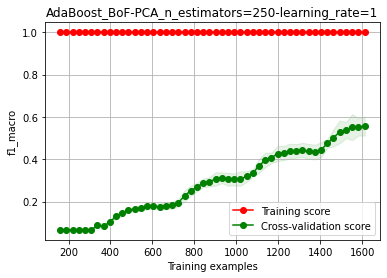

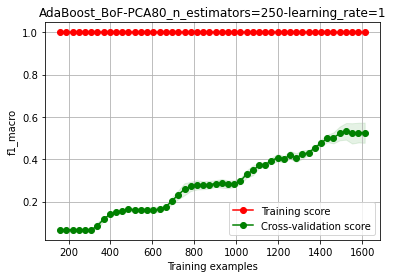

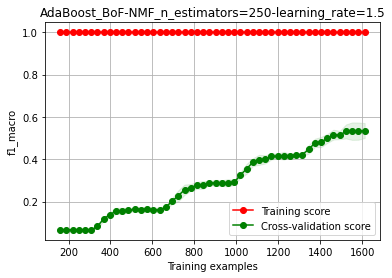

In [43]:
plotlearningcurve(model_name, param_dict, param_title_dictionary, 'f1_macro', 
                  train_sizes_dict, train_scores_mean_dict, 
                  train_scores_std_dict, test_scores_mean_dict,
                  test_scores_std_dict, path)

## Evaluating Performance Across Classes

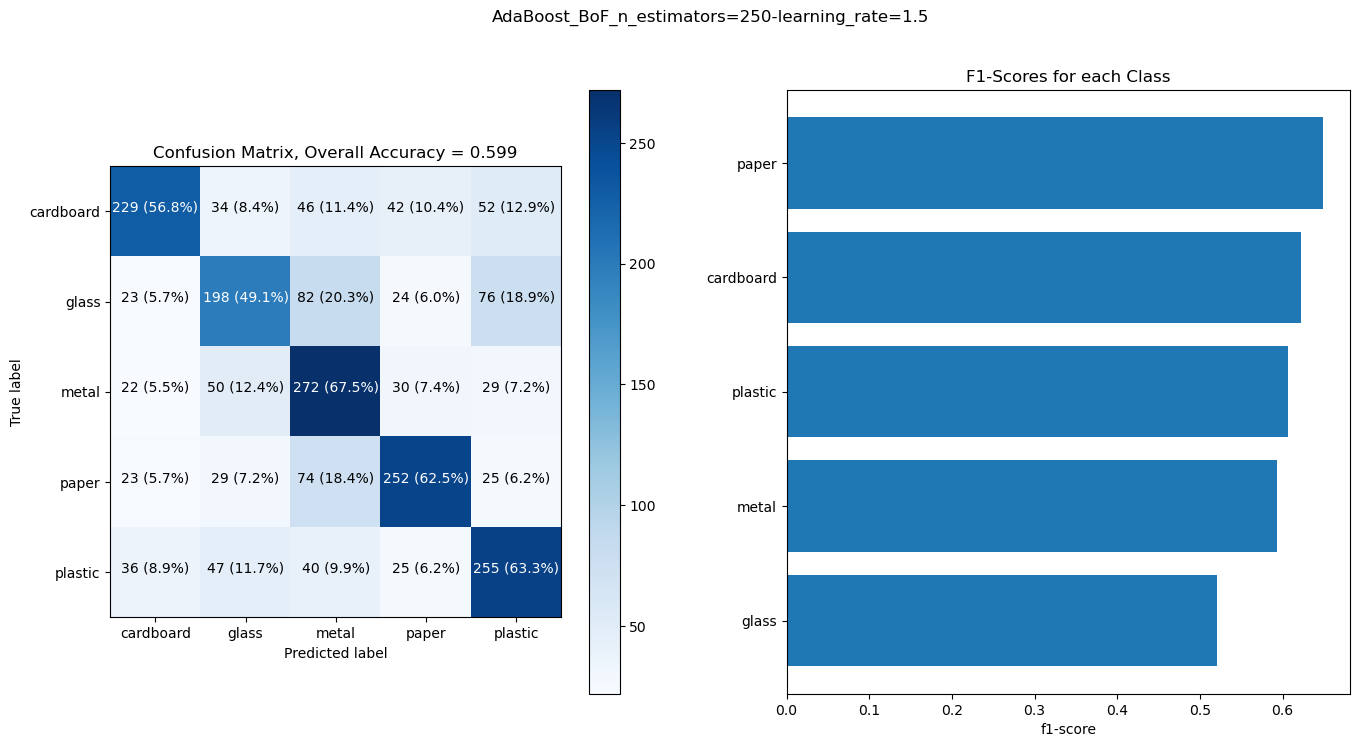

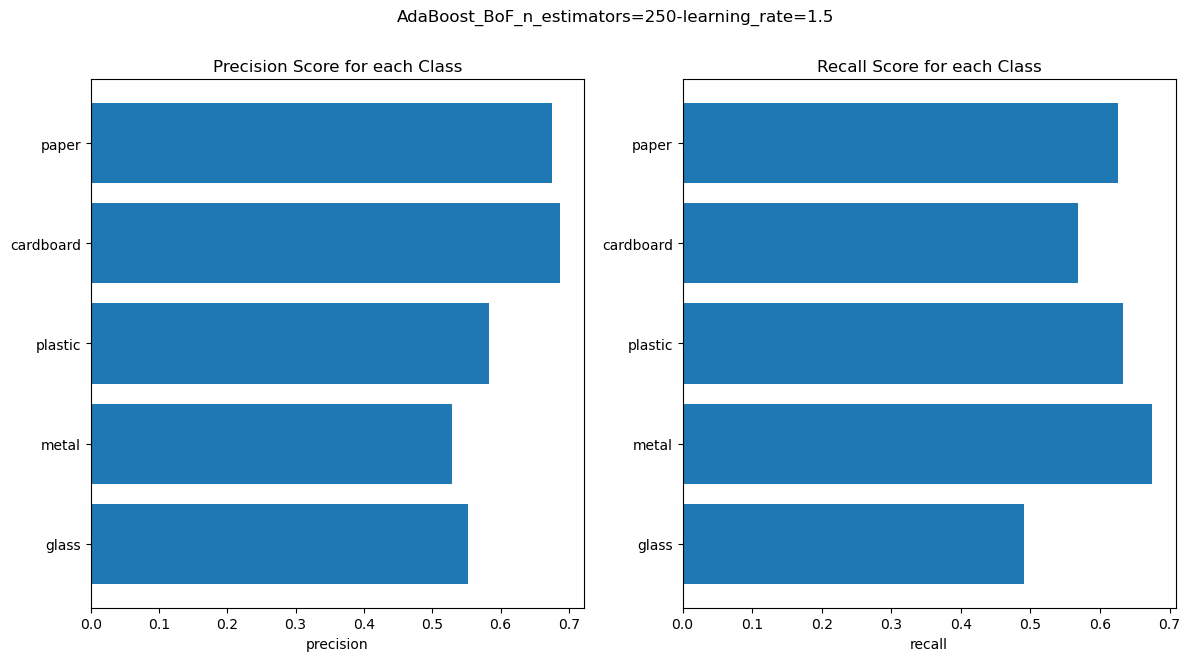

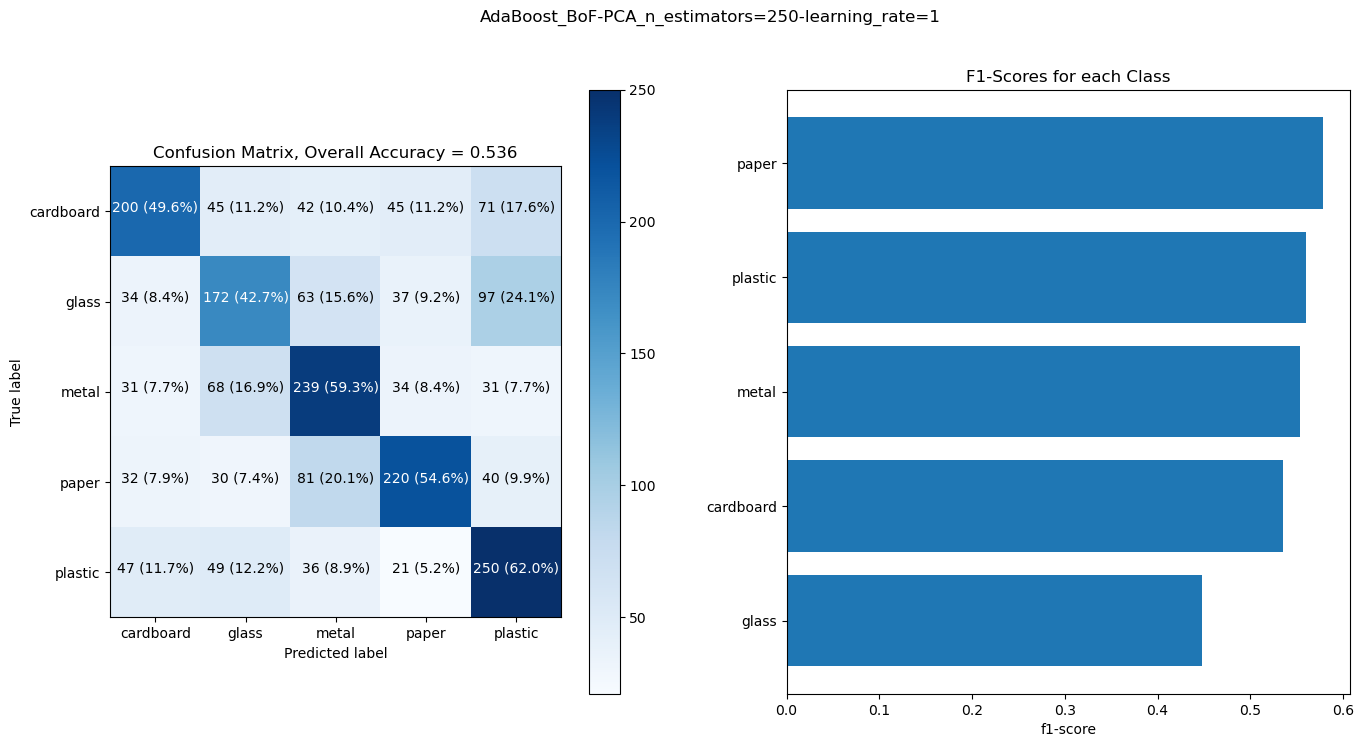

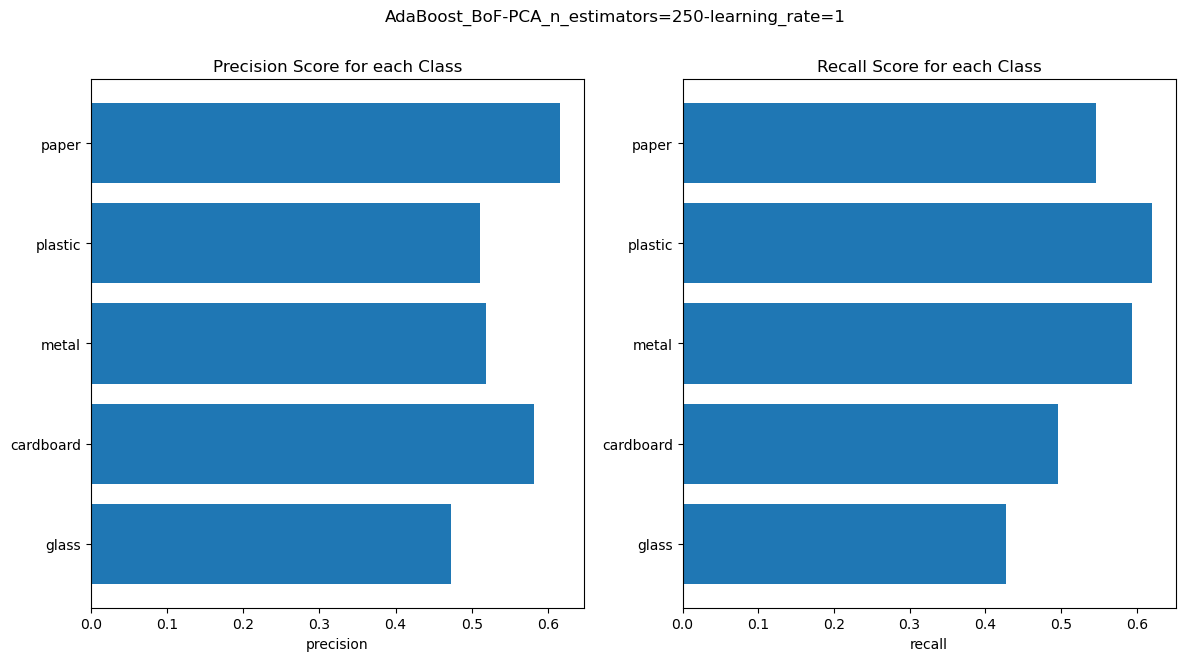

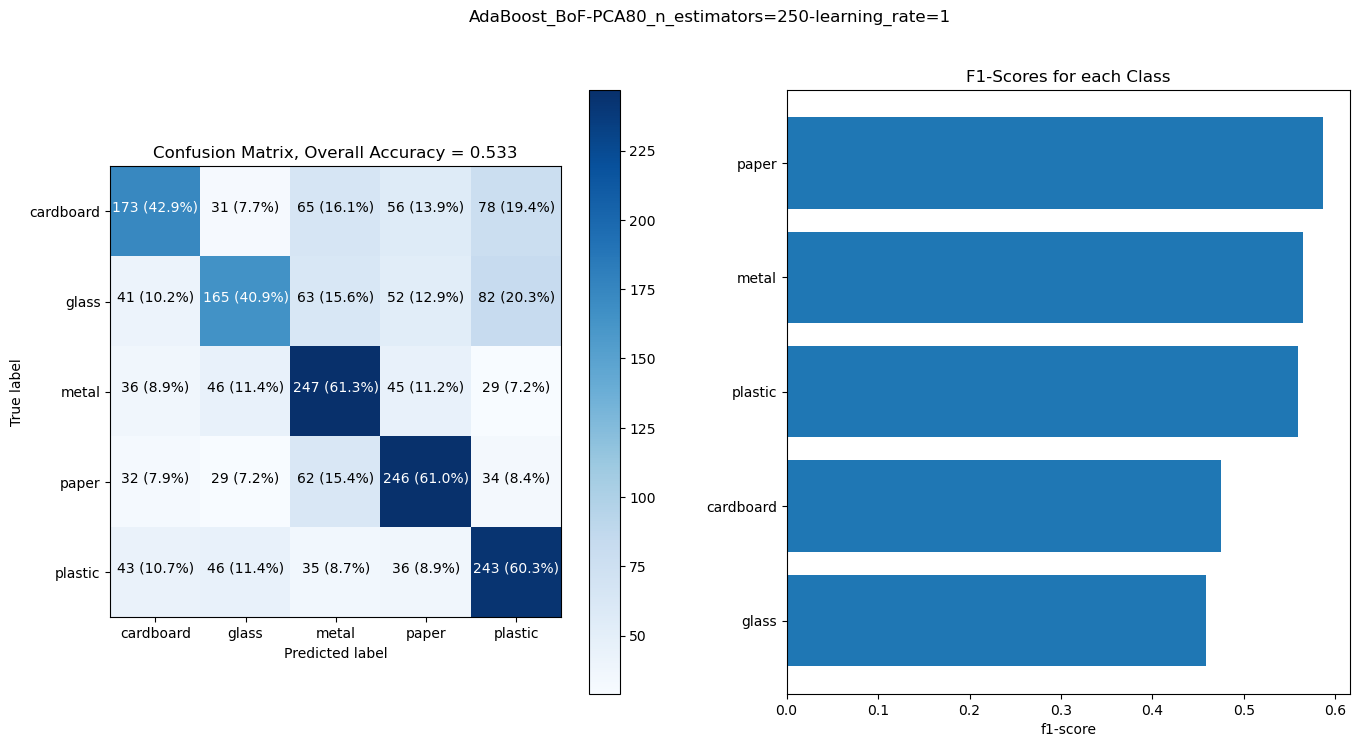

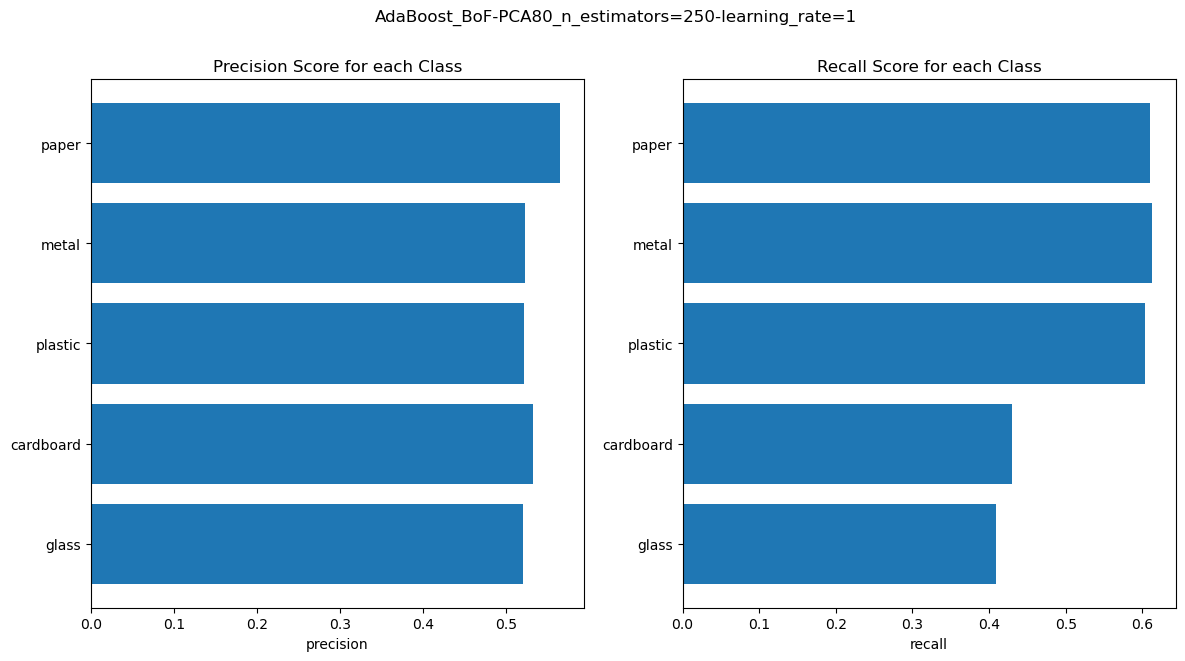

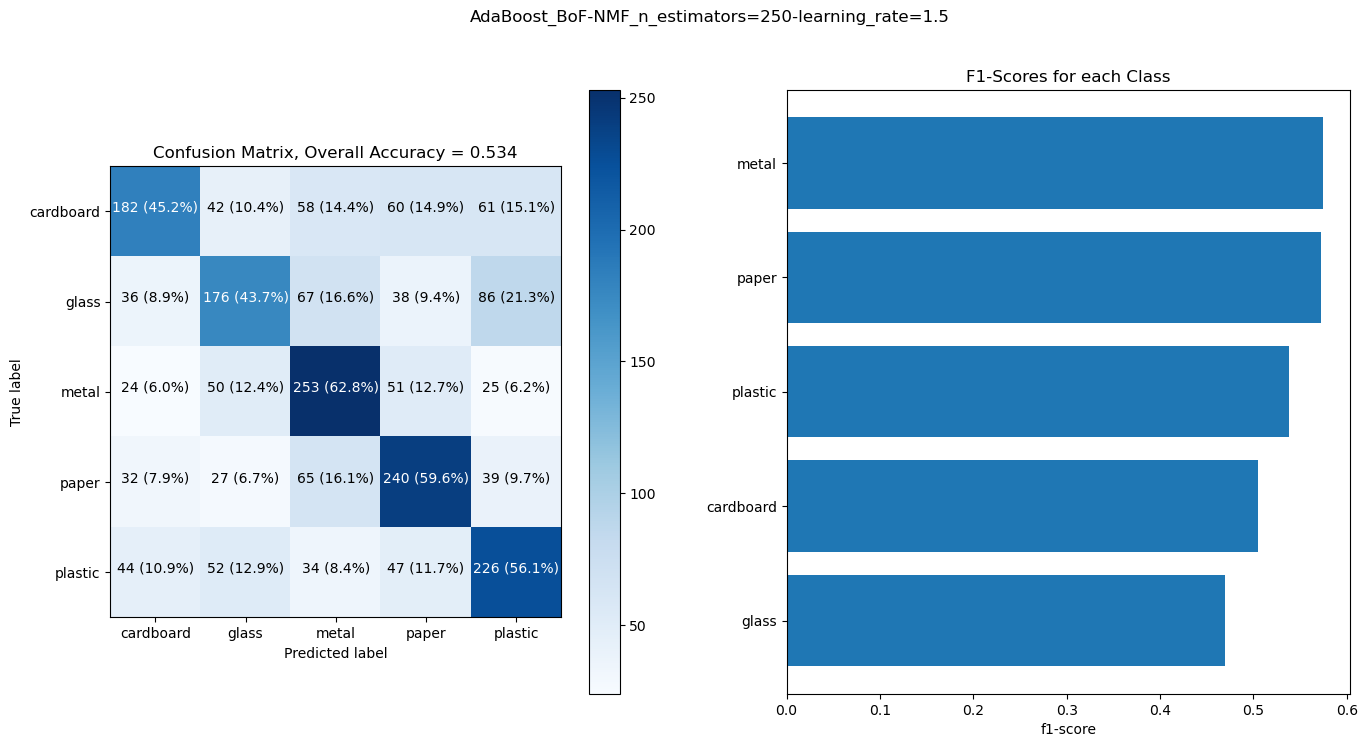

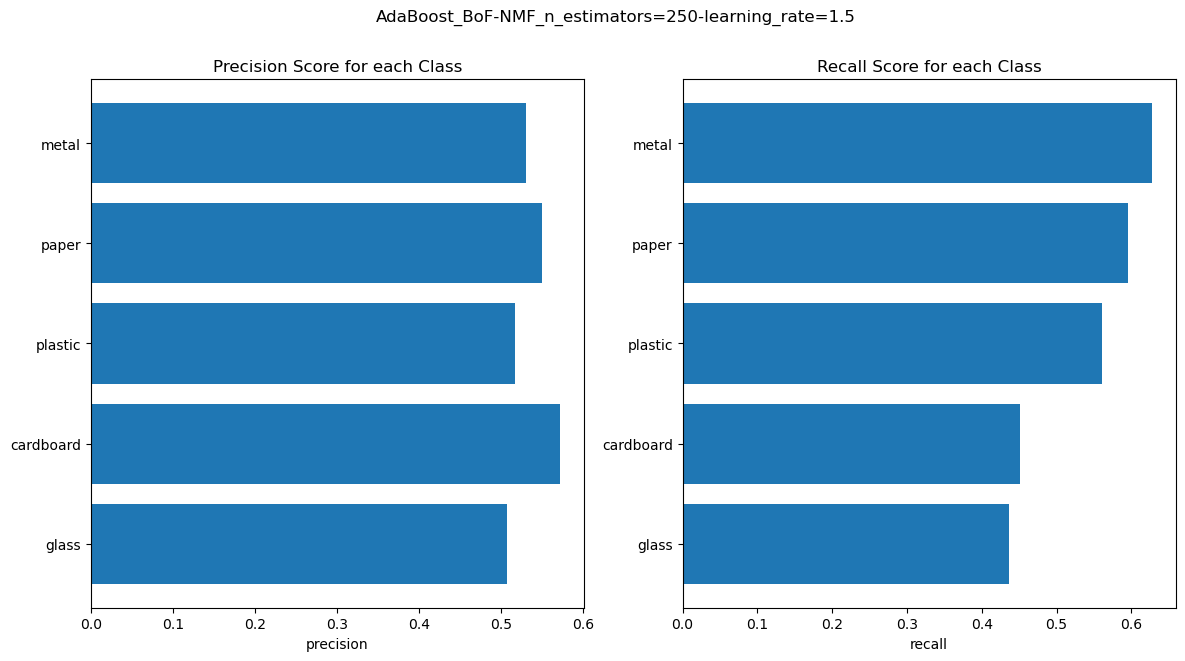

In [44]:
df, model_wrong_preds = multiclass_CV(model, 5, X_dict, y, param_dict, 
                                      param_title_dictionary, CLASSES, 
                                      model_name, path, image_filenames)

In [45]:
df

,model_name,accuracy,cardboard_f1_score,cardboard_precision,cardboard_recall,glass_f1_score,glass_precision,glass_recall,metal_f1_score,metal_precision,metal_recall,paper_f1_score,paper_precision,paper_recall,plastic_f1_score,plastic_precision,plastic_recall
0,AdaBoost_BoF_n_estimators=250-learning_rate=1.5,0.598511,0.622283,0.687688,0.568238,0.520368,0.553073,0.491315,0.593239,0.529183,0.674938,0.649485,0.675603,0.62531,0.607143,0.583524,0.632754
1,AdaBoost_BoF-PCA_n_estimators=250-learning_rate=1,0.536476,0.535475,0.581395,0.496278,0.448501,0.472527,0.426799,0.553241,0.518438,0.593052,0.578947,0.616246,0.545906,0.560538,0.511247,0.620347
2,AdaBoost_BoF-PCA80_n_estimators=250-learning_r...,0.533002,0.475275,0.532308,0.42928,0.458333,0.520505,0.409429,0.564571,0.523305,0.612903,0.587112,0.565517,0.610422,0.559264,0.521459,0.602978
3,AdaBoost_BoF-NMF_n_estimators=250-learning_rat...,0.534491,0.504854,0.572327,0.451613,0.469333,0.507205,0.436725,0.575,0.530398,0.627792,0.57211,0.550459,0.595533,0.538095,0.517162,0.560794


In [18]:
model_wrong_preds['BoF']

,img_path,y_true,y_pred,pred_prob,y_true_classname,y_pred_classname,pred_correct
296,/data/paper\paper172.jpg,3.0,0,0.928271,paper,cardboard,False
1910,/data/paper\paper75.jpg,3.0,0,0.922903,paper,cardboard,False
1183,/data/plastic\plastic327.jpg,4.0,1,0.847496,plastic,glass,False
606,/data/metal\metal210.jpg,2.0,3,0.846761,metal,paper,False
290,/data/paper\paper166.jpg,3.0,2,0.836211,paper,metal,False
...,...,...,...,...,...,...,...
1762,/data/glass\glass87.jpg,1.0,4,0.246141,glass,plastic,False
292,/data/paper\paper168.jpg,3.0,2,0.245355,paper,metal,False
1247,/data/cardboard\cardboard352.jpg,0.0,4,0.241939,cardboard,plastic,False
356,/data/plastic\plastic133.jpg,4.0,2,0.238527,plastic,metal,False


## Print Most Wrong Predictions

In [19]:
print_wrong_predictions(model_wrong_preds['BoF'], 10, image_generator, params)

FileNotFoundError: [Errno 2] No such file or directory: '/content//data/paper\\paper172.jpg'

## Storing Results

In [ ]:
copy_folder(path, destination)

Enter the experiment description:
